Code was taken from: https://blog.jovian.ai/generating-art-with-gans-352ceef3d51f 

It is a project that does the same thing that I am testing, but modifications needed to be made. 

While I use this code for only one artist at a time, the things I input into the dataset are to prove a point, not to destroy a data. 

# Modifications that can be made to Model:
 

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd "/content/drive/MyDrive/Senior I.S. /Data/Data_4/"

Mounted at /content/drive
/content/drive/MyDrive/Senior I.S. /Data/Data_4


In [3]:
# https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

batch_size = 128 #what is the bath size?- the size of the training set 
image_size = (64,64) #We need to resize each image
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #what are the stats - a tuple of two tuples 

In [4]:
'''
.compose(transformations)
Composes several transforms together. This transform does not support torchscript.
Please, see the note below.

Args:
    transforms (list of Transform objects): list of transforms to compose.
'''
#resizing the images so that they can be used in the model 
#normalizing them so that they look like squares that are relaticely the same size 

transform_ds = transforms.Compose([transforms.Resize(image_size),  
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])


In [5]:
train_ds = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/Senior I.S. /Data/Data",
                                     transform=transform_ds)


#why do we need to shuffle?
#What are num_workers? 
#what is pin_memory? 
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

757


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([3, 64, 64])


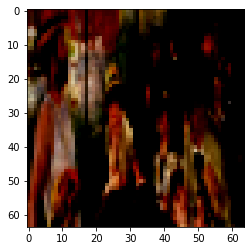

In [6]:
images,_ = train_ds[1]
print(images.size())
plt.imshow(images.permute(1,2,0))

#why are the images so dark? 

In [7]:
#creating a function that takes the tensors as input - no change needed 
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0] #what do the stats do - accessing a speific vectors coordinates 

## We can change: 
nmax=64 
figsize=(8, 8)


In [8]:
#creating two functions 
def show_images(images, nmax=64): #default to the size of the image 64px
    fig, ax = plt.subplots(figsize=(8, 8)) #what do subplots do? - We are resizing to get an 8x8 matrix
    ax.set_xticks([]); ax.set_yticks([]) #what do xticks and yticks do? 
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
#puts the original images in a grid 
def show_batch(dl, nmax=64): #max size is 64 
    for images, _ in dl:
        show_images(images, nmax)
        break

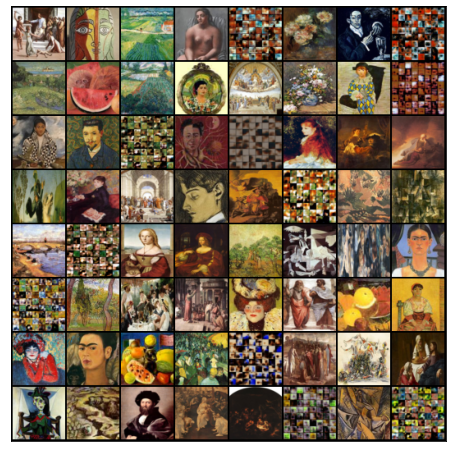

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cpu')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

## We can change 
The number of convolutions : 

  nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)

<br>

And the activation functions:

 nn.Sigmoid())


In [13]:
'''
.Sequential
A sequential container.
Modules will be added to it in the order they are passed in the
constructor. Alternatively, an OrderedDict of modules can be
passed in. The forward() method of Sequential accepts any
input and forwards it to the first module it contains. It then
"chains" outputs to inputs sequentially for each subsequent module,
finally returning the output of the last module.

The value a Sequential provides over manually calling a sequence
of modules is that it allows treating the whole container as a
single module, such that performing a transformation on the
Sequential applies to each of the modules it stores (which are
each a registered submodule of the Sequential).

What's the difference between a Sequential and a
torch.nn.ModuleList? A ModuleList is exactly what it
sounds like--a list for storing Module s! On the other hand,
the layers in a Sequential are connected in a cascading way.
'''
#nn comes from tensor flow for neural networks
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
  
    #Applies a 2D convolution over an input signal composed of several input planes.
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

The latent space itself has no meaning. Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one. Through training, the generator learns to map points into the latent space with specific output images and this mapping will be different each time the model is trained.

The latent space has structure when interpreted by the generator model, and this structure can be queried and navigated for a given model.

Typically, new images are generated using random points in the latent space. Taken a step further, points in the latent space can be constructed (e.g. all 0s, all 0.5s, or all 1s) and used as input or a query to generate a specific image.

In [15]:
latent_size = 150

YOu can modify the COVtranspose for the generator: 


nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


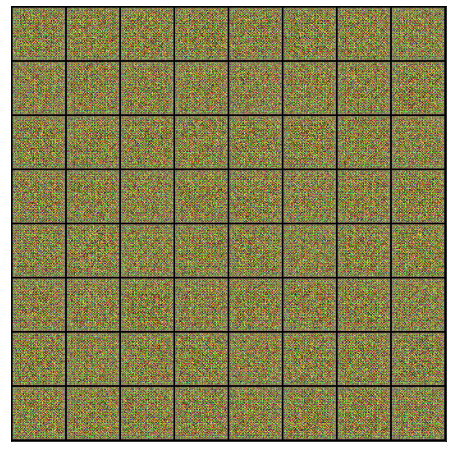

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
#fixed_latent = torch.randn(64, any, 1, 1, device=device)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


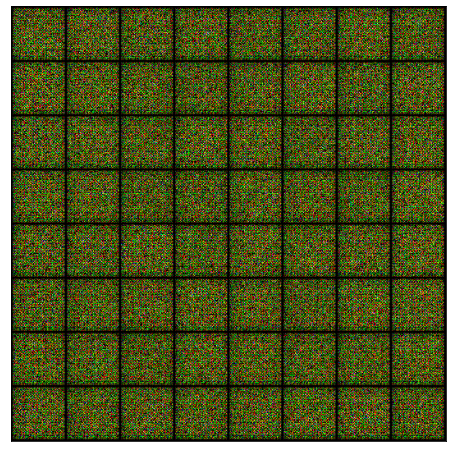

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

## WE CAN CHANGE: 
the optimizer function : Adam()
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))





In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

## We can change the 
learning rate 

and epochs 

In [28]:
lr = 0.001
epochs = 150

In [29]:
history = fit(epochs,lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 5.9505, loss_d: 0.1657, real_score: 0.8681, fake_score: 0.0029
Saving generated-images-0001.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 9.9185, loss_d: 0.0159, real_score: 0.9846, fake_score: 0.0000
Saving generated-images-0002.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 7.8661, loss_d: 0.0953, real_score: 0.9178, fake_score: 0.0008
Saving generated-images-0003.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 4.7097, loss_d: 0.4345, real_score: 0.9304, fake_score: 0.2718
Saving generated-images-0004.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 6.5751, loss_d: 0.1603, real_score: 0.9425, fake_score: 0.0821
Saving generated-images-0005.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 5.2739, loss_d: 0.1691, real_score: 0.9305, fake_score: 0.0821
Saving generated-images-0006.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 7.3075, loss_d: 0.4857, real_score: 0.9814, fake_score: 0.2851
Saving generated-images-0007.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 5.0750, loss_d: 0.1448, real_score: 0.9017, fake_score: 0.0189
Saving generated-images-0008.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 3.8409, loss_d: 0.2577, real_score: 0.8470, fake_score: 0.0411
Saving generated-images-0009.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 5.6688, loss_d: 0.1629, real_score: 0.8911, fake_score: 0.0058
Saving generated-images-0010.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 5.6588, loss_d: 0.2371, real_score: 0.9860, fake_score: 0.1893
Saving generated-images-0011.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 4.3442, loss_d: 0.1416, real_score: 0.9898, fake_score: 0.1183
Saving generated-images-0012.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 4.9510, loss_d: 0.2110, real_score: 0.9670, fake_score: 0.1404
Saving generated-images-0013.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 5.6596, loss_d: 0.7174, real_score: 0.7003, fake_score: 0.0223
Saving generated-images-0014.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 5.0920, loss_d: 0.1577, real_score: 0.9577, fake_score: 0.1020
Saving generated-images-0015.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 5.4457, loss_d: 0.0984, real_score: 0.9279, fake_score: 0.0189
Saving generated-images-0016.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 3.8527, loss_d: 0.6754, real_score: 0.9785, fake_score: 0.3964
Saving generated-images-0017.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 8.0134, loss_d: 0.6418, real_score: 0.9745, fake_score: 0.3924
Saving generated-images-0018.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 3.9408, loss_d: 0.1572, real_score: 0.9188, fake_score: 0.0562
Saving generated-images-0019.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 8.2751, loss_d: 0.4656, real_score: 0.9156, fake_score: 0.2725
Saving generated-images-0020.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 4.9516, loss_d: 0.0648, real_score: 0.9451, fake_score: 0.0035
Saving generated-images-0021.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 6.3801, loss_d: 0.2727, real_score: 0.9864, fake_score: 0.2015
Saving generated-images-0022.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 7.5724, loss_d: 0.4463, real_score: 0.9797, fake_score: 0.2992
Saving generated-images-0023.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 8.2352, loss_d: 4.3726, real_score: 0.0342, fake_score: 0.0002
Saving generated-images-0024.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 4.7812, loss_d: 0.2475, real_score: 0.8212, fake_score: 0.0339
Saving generated-images-0025.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 3.6390, loss_d: 0.1182, real_score: 0.9712, fake_score: 0.0797
Saving generated-images-0026.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 4.5004, loss_d: 0.2987, real_score: 0.8042, fake_score: 0.0311
Saving generated-images-0027.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 6.0407, loss_d: 0.0700, real_score: 0.9482, fake_score: 0.0145
Saving generated-images-0028.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 6.8986, loss_d: 0.9562, real_score: 0.9850, fake_score: 0.4187
Saving generated-images-0029.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 3.9990, loss_d: 0.4233, real_score: 0.7506, fake_score: 0.0722
Saving generated-images-0030.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 3.3710, loss_d: 0.0763, real_score: 0.9754, fake_score: 0.0479
Saving generated-images-0031.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 9.6198, loss_d: 1.5746, real_score: 0.9807, fake_score: 0.7025
Saving generated-images-0032.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 3.6908, loss_d: 0.1565, real_score: 0.9695, fake_score: 0.1107
Saving generated-images-0033.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 7.2874, loss_d: 0.3277, real_score: 0.7750, fake_score: 0.0330
Saving generated-images-0034.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 5.6521, loss_d: 0.0402, real_score: 0.9769, fake_score: 0.0159
Saving generated-images-0035.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 9.0235, loss_d: 0.5219, real_score: 0.9616, fake_score: 0.3569
Saving generated-images-0036.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 6.7545, loss_d: 1.2394, real_score: 0.9370, fake_score: 0.5016
Saving generated-images-0037.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 6.9491, loss_d: 0.3453, real_score: 0.9645, fake_score: 0.2437
Saving generated-images-0038.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 8.1367, loss_d: 0.7907, real_score: 0.9094, fake_score: 0.4357
Saving generated-images-0039.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 7.1991, loss_d: 0.5484, real_score: 0.9173, fake_score: 0.2962
Saving generated-images-0040.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 6.2764, loss_d: 0.2586, real_score: 0.9288, fake_score: 0.1532
Saving generated-images-0041.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 2.1145, loss_d: 1.4227, real_score: 0.3262, fake_score: 0.0079
Saving generated-images-0042.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 5.4634, loss_d: 0.3245, real_score: 0.7819, fake_score: 0.0340
Saving generated-images-0043.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 1.1641, loss_d: 1.5005, real_score: 0.3450, fake_score: 0.0195
Saving generated-images-0044.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 4.4955, loss_d: 0.2298, real_score: 0.8801, fake_score: 0.0720
Saving generated-images-0045.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 2.3397, loss_d: 0.3455, real_score: 0.9609, fake_score: 0.2315
Saving generated-images-0046.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 4.9979, loss_d: 0.1746, real_score: 0.8931, fake_score: 0.0454
Saving generated-images-0047.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 7.8471, loss_d: 1.1428, real_score: 0.9691, fake_score: 0.6164
Saving generated-images-0048.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 7.0214, loss_d: 0.6313, real_score: 0.9057, fake_score: 0.3725
Saving generated-images-0049.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 5.4350, loss_d: 0.1191, real_score: 0.9448, fake_score: 0.0562
Saving generated-images-0050.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 2.3826, loss_d: 1.0524, real_score: 0.5739, fake_score: 0.0217
Saving generated-images-0051.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 4.3173, loss_d: 0.5347, real_score: 0.7269, fake_score: 0.1193
Saving generated-images-0052.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 5.4879, loss_d: 0.6861, real_score: 0.9813, fake_score: 0.4346
Saving generated-images-0053.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 4.8304, loss_d: 0.1619, real_score: 0.9180, fake_score: 0.0668
Saving generated-images-0054.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 4.8479, loss_d: 0.0543, real_score: 0.9635, fake_score: 0.0151
Saving generated-images-0055.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 5.4818, loss_d: 0.0339, real_score: 0.9762, fake_score: 0.0090
Saving generated-images-0056.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 4.4032, loss_d: 0.1761, real_score: 0.9875, fake_score: 0.1376
Saving generated-images-0057.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 3.9059, loss_d: 0.3356, real_score: 0.9006, fake_score: 0.1632
Saving generated-images-0058.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 7.6295, loss_d: 0.6568, real_score: 0.9888, fake_score: 0.4096
Saving generated-images-0059.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 5.0638, loss_d: 0.1504, real_score: 0.9860, fake_score: 0.1214
Saving generated-images-0060.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 6.7519, loss_d: 0.6193, real_score: 0.5932, fake_score: 0.0023
Saving generated-images-0061.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 5.2574, loss_d: 0.1500, real_score: 0.9794, fake_score: 0.1168
Saving generated-images-0062.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 9.5037, loss_d: 0.8577, real_score: 0.9930, fake_score: 0.5001
Saving generated-images-0063.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 4.2003, loss_d: 0.3560, real_score: 0.9430, fake_score: 0.2201
Saving generated-images-0064.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 3.4799, loss_d: 0.6745, real_score: 0.6083, fake_score: 0.0341
Saving generated-images-0065.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 7.4424, loss_d: 0.5179, real_score: 0.9618, fake_score: 0.3416
Saving generated-images-0066.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 4.3154, loss_d: 0.2860, real_score: 0.9753, fake_score: 0.2041
Saving generated-images-0067.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 3.4793, loss_d: 0.3797, real_score: 0.7936, fake_score: 0.0979
Saving generated-images-0068.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 2.3855, loss_d: 0.0457, real_score: 0.9906, fake_score: 0.0350
Saving generated-images-0069.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 6.5422, loss_d: 0.4792, real_score: 0.8692, fake_score: 0.2534
Saving generated-images-0070.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 6.0313, loss_d: 0.2576, real_score: 0.9308, fake_score: 0.1546
Saving generated-images-0071.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 5.8187, loss_d: 3.2296, real_score: 0.0860, fake_score: 0.0001
Saving generated-images-0072.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 8.1436, loss_d: 0.8462, real_score: 0.5216, fake_score: 0.0044
Saving generated-images-0073.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 7.9844, loss_d: 0.9137, real_score: 0.9562, fake_score: 0.4969
Saving generated-images-0074.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 5.9811, loss_d: 0.1706, real_score: 0.9650, fake_score: 0.1148
Saving generated-images-0075.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 2.8019, loss_d: 0.1369, real_score: 0.9743, fake_score: 0.0975
Saving generated-images-0076.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 4.4156, loss_d: 0.2568, real_score: 0.8771, fake_score: 0.0974
Saving generated-images-0077.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 6.8729, loss_d: 0.5254, real_score: 0.7734, fake_score: 0.0085
Saving generated-images-0078.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 3.8969, loss_d: 0.2264, real_score: 0.9317, fake_score: 0.1222
Saving generated-images-0079.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 10.5200, loss_d: 0.7856, real_score: 0.9382, fake_score: 0.4791
Saving generated-images-0080.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 3.3344, loss_d: 0.1676, real_score: 0.9837, fake_score: 0.1313
Saving generated-images-0081.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 5.4557, loss_d: 0.1512, real_score: 0.9057, fake_score: 0.0416
Saving generated-images-0082.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 5.7388, loss_d: 0.0667, real_score: 0.9526, fake_score: 0.0159
Saving generated-images-0083.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 5.7925, loss_d: 2.4626, real_score: 0.1369, fake_score: 0.0025
Saving generated-images-0084.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 4.2679, loss_d: 0.1784, real_score: 0.9740, fake_score: 0.1252
Saving generated-images-0085.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 5.3912, loss_d: 0.1919, real_score: 0.8447, fake_score: 0.0055
Saving generated-images-0086.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 4.8327, loss_d: 0.1926, real_score: 0.8782, fake_score: 0.0481
Saving generated-images-0087.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 5.9551, loss_d: 3.4307, real_score: 0.2262, fake_score: 0.0011
Saving generated-images-0088.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 5.5661, loss_d: 0.1728, real_score: 0.9712, fake_score: 0.1236
Saving generated-images-0089.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 5.2954, loss_d: 0.4297, real_score: 0.7104, fake_score: 0.0123
Saving generated-images-0090.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 8.7541, loss_d: 0.4913, real_score: 0.9927, fake_score: 0.3456
Saving generated-images-0091.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 11.1510, loss_d: 0.8280, real_score: 0.9846, fake_score: 0.5068
Saving generated-images-0092.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 7.1068, loss_d: 0.9887, real_score: 0.9955, fake_score: 0.5057
Saving generated-images-0093.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 6.7254, loss_d: 0.3578, real_score: 0.7290, fake_score: 0.0015
Saving generated-images-0094.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 5.2613, loss_d: 0.0411, real_score: 0.9842, fake_score: 0.0243
Saving generated-images-0095.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 4.9362, loss_d: 0.7560, real_score: 0.7812, fake_score: 0.1217
Saving generated-images-0096.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 5.4755, loss_d: 0.2694, real_score: 0.9327, fake_score: 0.1568
Saving generated-images-0097.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 5.5326, loss_d: 0.1088, real_score: 0.9612, fake_score: 0.0619
Saving generated-images-0098.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 5.0863, loss_d: 0.4085, real_score: 0.7580, fake_score: 0.0203
Saving generated-images-0099.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 10.3271, loss_d: 1.2803, real_score: 0.9888, fake_score: 0.6513
Saving generated-images-0100.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 3.2429, loss_d: 0.2419, real_score: 0.8298, fake_score: 0.0282
Saving generated-images-0101.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 6.2199, loss_d: 0.3981, real_score: 0.9415, fake_score: 0.2633
Saving generated-images-0102.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 4.0852, loss_d: 0.1860, real_score: 0.8748, fake_score: 0.0395
Saving generated-images-0103.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 4.5730, loss_d: 0.3866, real_score: 0.9970, fake_score: 0.2539
Saving generated-images-0104.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 6.0703, loss_d: 0.2384, real_score: 0.8358, fake_score: 0.0213
Saving generated-images-0105.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 4.7659, loss_d: 0.1540, real_score: 0.9149, fake_score: 0.0566
Saving generated-images-0106.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 4.0857, loss_d: 2.3617, real_score: 0.3083, fake_score: 0.0097
Saving generated-images-0107.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 6.0950, loss_d: 0.5068, real_score: 0.9876, fake_score: 0.3498
Saving generated-images-0108.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 4.3581, loss_d: 0.2144, real_score: 0.8521, fake_score: 0.0267
Saving generated-images-0109.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 8.9386, loss_d: 1.0253, real_score: 0.9626, fake_score: 0.5749
Saving generated-images-0110.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 4.3307, loss_d: 0.2147, real_score: 0.8725, fake_score: 0.0436
Saving generated-images-0111.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 6.0467, loss_d: 0.7640, real_score: 0.9622, fake_score: 0.4407
Saving generated-images-0112.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 7.3598, loss_d: 2.4568, real_score: 0.2452, fake_score: 0.0054
Saving generated-images-0113.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 5.9655, loss_d: 0.0954, real_score: 0.9816, fake_score: 0.0670
Saving generated-images-0114.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 5.1679, loss_d: 0.1517, real_score: 0.9873, fake_score: 0.1207
Saving generated-images-0115.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 10.3790, loss_d: 0.6862, real_score: 0.6420, fake_score: 0.0004
Saving generated-images-0116.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 4.4360, loss_d: 0.2825, real_score: 0.8496, fake_score: 0.0806
Saving generated-images-0117.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 2.9085, loss_d: 0.6214, real_score: 0.6643, fake_score: 0.0629
Saving generated-images-0118.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 5.1496, loss_d: 0.0847, real_score: 0.9684, fake_score: 0.0419
Saving generated-images-0119.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 5.9513, loss_d: 0.2797, real_score: 0.9634, fake_score: 0.1897
Saving generated-images-0120.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 5.5100, loss_d: 0.3708, real_score: 0.7322, fake_score: 0.0090
Saving generated-images-0121.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 3.0792, loss_d: 0.1152, real_score: 0.9755, fake_score: 0.0818
Saving generated-images-0122.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 6.1929, loss_d: 0.4659, real_score: 0.9915, fake_score: 0.2696
Saving generated-images-0123.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 4.9568, loss_d: 0.0789, real_score: 0.9713, fake_score: 0.0459
Saving generated-images-0124.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 4.4245, loss_d: 0.1496, real_score: 0.9398, fake_score: 0.0756
Saving generated-images-0125.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 5.6110, loss_d: 0.1521, real_score: 0.8948, fake_score: 0.0301
Saving generated-images-0126.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 4.5053, loss_d: 0.0957, real_score: 0.9506, fake_score: 0.0388
Saving generated-images-0127.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 5.8260, loss_d: 0.1731, real_score: 0.9608, fake_score: 0.1142
Saving generated-images-0128.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 5.5764, loss_d: 0.2329, real_score: 0.9675, fake_score: 0.1460
Saving generated-images-0129.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 5.5039, loss_d: 0.1694, real_score: 0.8686, fake_score: 0.0181
Saving generated-images-0130.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 8.7933, loss_d: 0.7680, real_score: 0.9924, fake_score: 0.4650
Saving generated-images-0131.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 6.1544, loss_d: 0.5741, real_score: 0.6670, fake_score: 0.0254
Saving generated-images-0132.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 6.8383, loss_d: 1.8959, real_score: 0.2791, fake_score: 0.0021
Saving generated-images-0133.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 4.9270, loss_d: 0.4884, real_score: 0.7093, fake_score: 0.0573
Saving generated-images-0134.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 5.1524, loss_d: 0.8600, real_score: 0.6762, fake_score: 0.0994
Saving generated-images-0135.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 5.4527, loss_d: 0.2856, real_score: 0.9080, fake_score: 0.1543
Saving generated-images-0136.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 8.5748, loss_d: 1.5373, real_score: 0.9766, fake_score: 0.6332
Saving generated-images-0137.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 8.8706, loss_d: 1.2276, real_score: 0.9358, fake_score: 0.5891
Saving generated-images-0138.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 7.5596, loss_d: 0.5275, real_score: 0.9733, fake_score: 0.2808
Saving generated-images-0139.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 7.6327, loss_d: 0.4596, real_score: 0.9127, fake_score: 0.2677
Saving generated-images-0140.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 3.7350, loss_d: 0.1416, real_score: 0.9193, fake_score: 0.0462
Saving generated-images-0141.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 8.3850, loss_d: 0.7263, real_score: 0.9850, fake_score: 0.3541
Saving generated-images-0142.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 5.8862, loss_d: 1.1953, real_score: 0.5698, fake_score: 0.3417
Saving generated-images-0143.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 7.6797, loss_d: 0.5278, real_score: 0.9844, fake_score: 0.3372
Saving generated-images-0144.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 4.6710, loss_d: 0.2310, real_score: 0.8513, fake_score: 0.0375
Saving generated-images-0145.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 3.8555, loss_d: 0.1656, real_score: 0.9815, fake_score: 0.1267
Saving generated-images-0146.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 5.0958, loss_d: 0.4942, real_score: 0.9638, fake_score: 0.3117
Saving generated-images-0147.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 3.3033, loss_d: 3.0545, real_score: 0.1800, fake_score: 0.0076
Saving generated-images-0148.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 7.5461, loss_d: 0.7693, real_score: 0.9090, fake_score: 0.3825
Saving generated-images-0149.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 6.5335, loss_d: 0.3418, real_score: 0.9207, fake_score: 0.1860
Saving generated-images-0150.png


In [30]:
from IPython.display import Image 

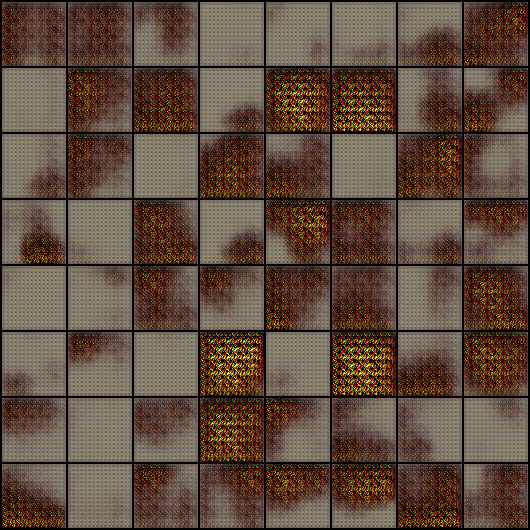

In [31]:
Image('./generated/generated-images-0013.png')

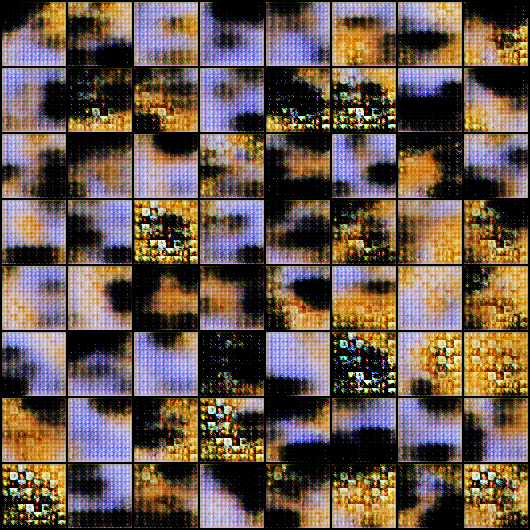

In [32]:
Image('./generated/generated-images-0037.png')

In [33]:
losses_g, losses_d, real_scores, fake_scores = history

In [34]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

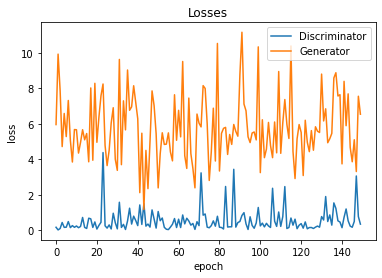

In [35]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

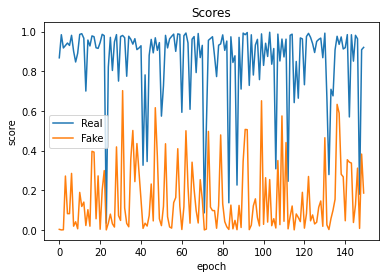

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');